### Import lots of Stuff

In [118]:
#https://www.kaggle.com/redwankarimsony/pulmonary-fibrosis-progression-interactive-eda
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import tqdm
from typing import Dict
import matplotlib.pyplot as plt

#plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

#color
from colorama import Fore, Back, Style
import seaborn as sns
sns.set(style="whitegrid")

#pydicom
import pydicom

# Settings for pretty nice plots
plt.style.use('fivethirtyeight')

### What are the .csv files like??

In [119]:
train_df = pd.read_csv('osic-pulmonary-fibrosis-progression/train.csv')
test_df = pd.read_csv('osic-pulmonary-fibrosis-progression/test.csv')

#basic info
print(Fore.YELLOW + 'Train Set !!',Style.RESET_ALL)
print(train_df.info())
print('-------------')
print(Fore.BLUE + 'Test Set !!',Style.RESET_ALL)
print(test_df.info())


Train Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB
None
-------------
Test Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        5 non-null      object 
 1   Weeks          5 non-null      int64  
 2   FVC            5 non-null      int64  
 3   Percent        5 non-null      float64
 4   Age            5 non

## Exploring the Patients in the CSV Data Set 

In [120]:
# Total number of Patient entries in the dataset(train+test)
print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
print(Fore.BLUE +"Total Patients in Test set: ",Style.RESET_ALL,test_df['Patient'].count())

# How many unique patients in train?
print(Fore.GREEN + "Unique ids:", Style.RESET_ALL, f"{train_df['Patient'].value_counts().shape[0]}.")

Total Patients in Train set:   1549
Total Patients in Test set:   5
Unique ids:  176.


### Number of images

In [121]:
files = 0
path = "osic-pulmonary-fibrosis-progression/train"

for _, dirnames, filenames in os.walk(path):
    files += len(filenames)
    folders += len(dirnames)
print(Fore.YELLOW +f'{files:,}',Style.RESET_ALL,"files/images, " + Fore.BLUE + f'{folders:,}',Style.RESET_ALL ,'folders/patients')

33,026  files/images, 880  folders/patients


### Files Per Patient

In [122]:
files = []
for _, dirnames, filenames in os.walk(path):
    files.append(len(filenames))

print(Fore.YELLOW +f'{round(np.mean(files)):,}',Style.RESET_ALL,'average files/images per patient')
print(Fore.BLUE +f'{round(np.max(files)):,}',Style.RESET_ALL, 'max files/images per patient')
print(Fore.GREEN +f'{round(np.min(files)):,}',Style.RESET_ALL,'min files/images per patient')

187  average files/images per patient
1,018  max files/images per patient
0  min files/images per patient


As we can see the number of rows of data as well as the number of images per patient is more than one. The rows of data is greater than one because every patient has multiple given FVC readings. There is more than one image per patient because a CT scan consists of more than one image.

In [123]:
file= pd.DataFrame(files)
file.iplot(kind='hist',
                              xTitle='Number of Files', 
                              yTitle='Counts',
                              linecolor='black', 
                              opacity=0.7,
                              color='#FB8072',
                              theme='pearl',
                              bargap=0.2,
                              gridcolor='white',
                              title='Distribution of the Number of Files per Patient')

### Distribution of weeks and number of FVC measurements in the training set

In [124]:
train_df['Weeks'].iplot(kind='hist',
                              xTitle='Weeks', 
                              yTitle='Counts',
                              linecolor='black', 
                              opacity=0.7,
                              color='#FB8072',
                              theme='pearl',
                              bargap=0.2,
                              gridcolor='white',
                              title='Distribution of the Weeks in the training set')

There are some negative values in weeks. These signify measurements taken before the baseline CT scan. This also shows the distribution of the number of FVC values we have per patient. Since weeks correlates perfectly to FVC, ie for every week a patient went in he would have a corresponding FVC value for that week. 

### Age and Sex against FVC

In [125]:
fig = px.scatter(train_df, x="FVC", y="Age", color='Sex')
fig.show()

There is a clear difference in FVC measurements for females and males. Males tend to have higher FVC measrurements. The trend between FVC and age slightly less apparent, but on the whole older people have lower FVC values. 

### Sample Patients FVC vs Weeks

In [126]:
patient1 = train_df[train_df.Patient == 'ID00007637202177411956430']
patient2 = train_df[train_df.Patient == 'ID00009637202177434476278']
patient3 = train_df[train_df.Patient == 'ID00010637202177584971671']
patient4 = train_df[train_df.Patient == 'ID00011637202177653955184']
patients = [patient1 ,patient2, patient3, patient4]
fig = px.line(pd.concat(patients), x="Weeks", y="FVC", color='Patient')
fig.show()

As we can see for most of the patients, FVC decreases as the weeks go by. However there are irregularities and some variations in FVC in that it does not always go down. Furthermore the amount it decreases by is also very variable. 

### Age Distribution of Patients

In [127]:
patient_df['Age'].iplot(kind='hist',bins=30,color='blue',xTitle='Ages',yTitle='Count')

# Visualizing Dicom Images

### Data Contained within a DICOM:

Filename.........:  osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347/16.dcm

Patient's name......:  ID00296637202279895784347, 
Patient id..........:  ID00296637202279895784347
Patient's Sex.......:  
Modality............:  CT
Body Part Examined..:  Chest
Image size.......:   512 x 512, 524288 bytes
Pixel spacing....:  [0.714844, 0.714844]


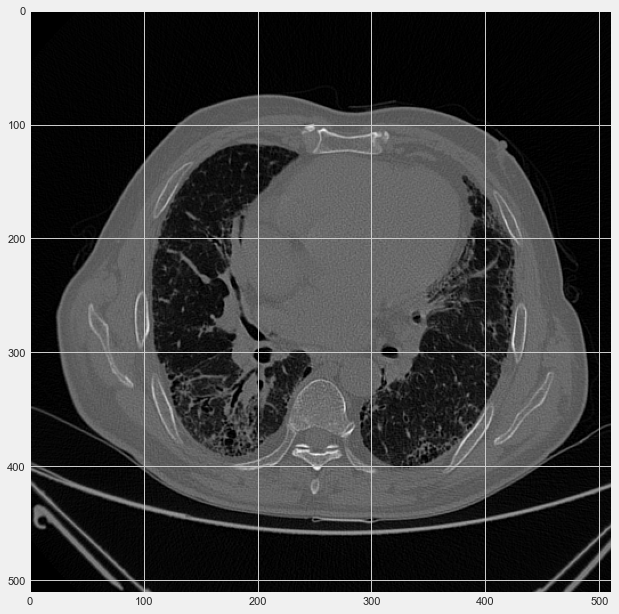

In [128]:
# https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data
def show_dcm_info(dataset):
    print(Fore.YELLOW + "Filename.........:",Style.RESET_ALL,file_path)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print(Fore.BLUE + "Patient's name......:",Style.RESET_ALL, display_name)
    print(Fore.BLUE + "Patient id..........:",Style.RESET_ALL, dataset.PatientID)
    print(Fore.BLUE + "Patient's Sex.......:",Style.RESET_ALL, dataset.PatientSex)
    print(Fore.YELLOW + "Modality............:",Style.RESET_ALL, dataset.Modality)
    print(Fore.GREEN + "Body Part Examined..:",Style.RESET_ALL, dataset.BodyPartExamined)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print(Fore.BLUE + "Image size.......:",Style.RESET_ALL," {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print(Fore.YELLOW + "Pixel spacing....:",Style.RESET_ALL,dataset.PixelSpacing)
            dataset.PixelSpacing = [1, 1]
        plt.figure(figsize=(10, 10))
        plt.imshow(dataset.pixel_array, cmap='gray')
        plt.show()
        
for file_path in glob.glob('osic-pulmonary-fibrosis-progression/train/*/*.dcm'):
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    break

### Seeing a few sections of a singular patients CT scan:

Total images for patient ID00123637202217151272140:  258
Showing first 16 Scans:


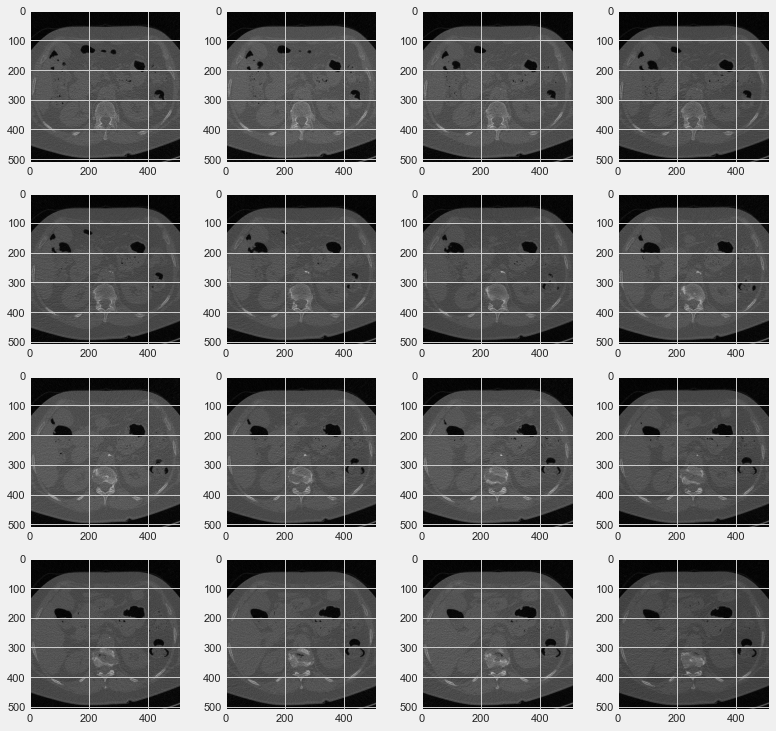

In [129]:
imdir = "osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140"
print("Total images for patient ID00123637202217151272140: ", len(os.listdir(imdir)))
print("Showing first 16 Scans:")

# view first (columns*rows) images in order
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 4
imglist = os.listdir(imdir)
for i in range(1, columns*rows +1):
    filename = imdir + "/" + str(i) + ".dcm"
    ds = pydicom.dcmread(filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap='gray')
plt.show()

There is a lot of data and information present within these CT scans, and so they should help predict FVC quite well if we can properly train a model. 